In [1]:
! pip install lightgbm

In [35]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


random.seed(42)

In [3]:
df_all = pd.read_csv('~/work/project/clean_df.csv')
df_all['time_close'] = pd.to_datetime(df_all['time_close'])
# df_all = df_all.loc[df_all['time_close'] > '2021-07-01']
df = df_all.loc[df_all['symbol_id'] == 'LTC_2'].copy().reset_index(drop=True)
symbols = ['DOGE_74', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']
for sym in symbols:
    df[sym] = df_all.loc[df_all['symbol_id'] ==  sym]['close'].values
    df[(sym + ' change')] = df_all.loc[df_all['symbol_id'] ==  sym]['price change'].values
df.drop(columns=['symbol_id', 'tomorrow change'], inplace=True)
df['target'] = df['close'].shift()
df.head()

,time_close,close,volume,marketcap,month,day,weekday,day of week,price change,volume change,...,ETH_1027 change,XRP_52,XRP_52 change,XLM_512,XLM_512 change,BTC_1,BTC_1 change,XMR_328,XMR_328 change,target
0,2020-09-24,43.575650,1.723047e+09,2.855191e+09,9,24,3,1,-0.021570,-0.030759,...,-0.059389,0.222924,-0.045198,0.068613,-0.041776,10295.054804,-0.021312,88.404357,-0.051886,NaN
1,2020-09-25,44.790372,2.027335e+09,2.935124e+09,9,25,4,1,0.027876,0.176599,...,0.078154,0.231864,0.040102,0.070204,0.023188,10773.534000,0.046477,91.695987,0.037234,43.575650
2,2020-09-26,46.090238,1.852828e+09,3.020641e+09,9,26,5,0,0.029021,-0.086077,...,0.010122,0.243233,0.049036,0.074894,0.066801,10668.141934,-0.009782,93.026053,0.014505,44.790372
3,2020-09-27,46.340146,2.191838e+09,3.037367e+09,9,27,6,0,0.005422,0.182969,...,0.021704,0.243122,-0.000456,0.074085,-0.010805,10769.604523,0.009511,95.044383,0.021696,46.090238
4,2020-09-28,46.434781,2.217909e+09,3.043916e+09,9,28,0,1,0.002042,0.011895,...,-0.002503,0.244379,0.005170,0.074022,-0.000851,10881.984006,0.010435,97.741001,0.028372,46.340146


In [4]:
df['EMA_9'] = df['close'].ewm(9).mean().shift()
df['SMA_5'] = df['close'].rolling(5).mean().shift()
df['SMA_10'] = df['close'].rolling(10).mean().shift()
df['SMA_30'] = df['close'].rolling(30).mean().shift()

In [5]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)

In [6]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [7]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,time_close,close,volume,marketcap,month,day,weekday,day of week,price change,volume change,...,XMR_328,XMR_328 change,target,EMA_9,SMA_5,SMA_10,SMA_30,RSI,MACD,MACD_signal
0,2020-10-27,57.230768,3.661526e+09,3.762996e+09,10,27,1,1,-0.028926,-0.024228,...,134.556445,0.021805,58.935549,51.453524,56.077218,51.769093,48.814861,67.465565,2.322216,1.552770
1,2020-10-28,58.362675,3.507820e+09,3.837731e+09,10,28,2,1,0.019778,-0.041979,...,134.733687,0.001317,57.230768,52.047776,56.639998,52.760699,49.177882,69.757214,2.499150,1.764814
2,2020-10-29,55.833562,3.776423e+09,3.671716e+09,10,29,3,1,-0.043334,0.076573,...,126.596604,-0.060394,58.362675,52.695479,57.598479,53.875261,49.575478,63.630137,2.418586,1.907856
3,2020-10-30,55.539861,3.003985e+09,3.652735e+09,10,30,4,1,-0.005260,-0.204542,...,124.943753,-0.013056,55.833562,53.016520,57.771255,54.732499,49.910108,63.272466,2.305548,1.993263
4,2020-10-31,54.657660,6.788779e+09,3.595100e+09,10,31,5,0,-0.015884,1.259925,...,122.971292,-0.015787,55.539861,53.274076,57.180483,55.481676,50.241818,67.302290,2.123690,2.020866


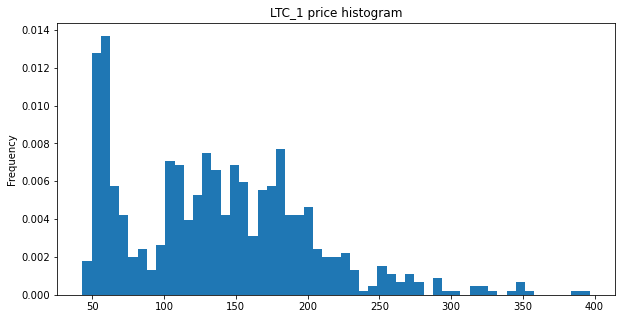

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
df['target'].plot.hist(density=1, bins=55, ax=ax)
plt.title('LTC_1 price histogram')
plt.show()

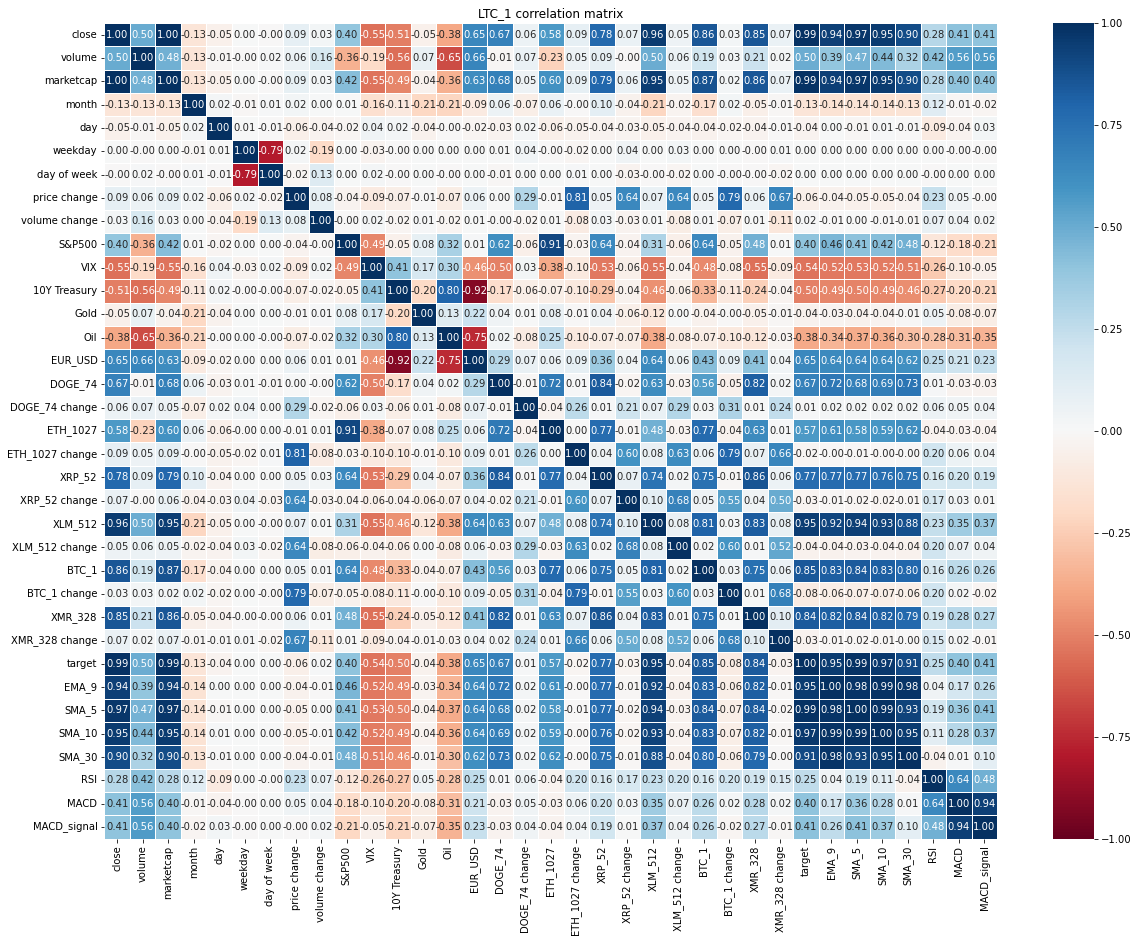

In [9]:
fig, ax = plt.subplots(figsize = (20, 15))
corrmat = df.drop(columns='time_close').corr()
sns.heatmap(corrmat, cmap="RdBu", linewidths=.5, vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('LTC_1 correlation matrix')
plt.show()

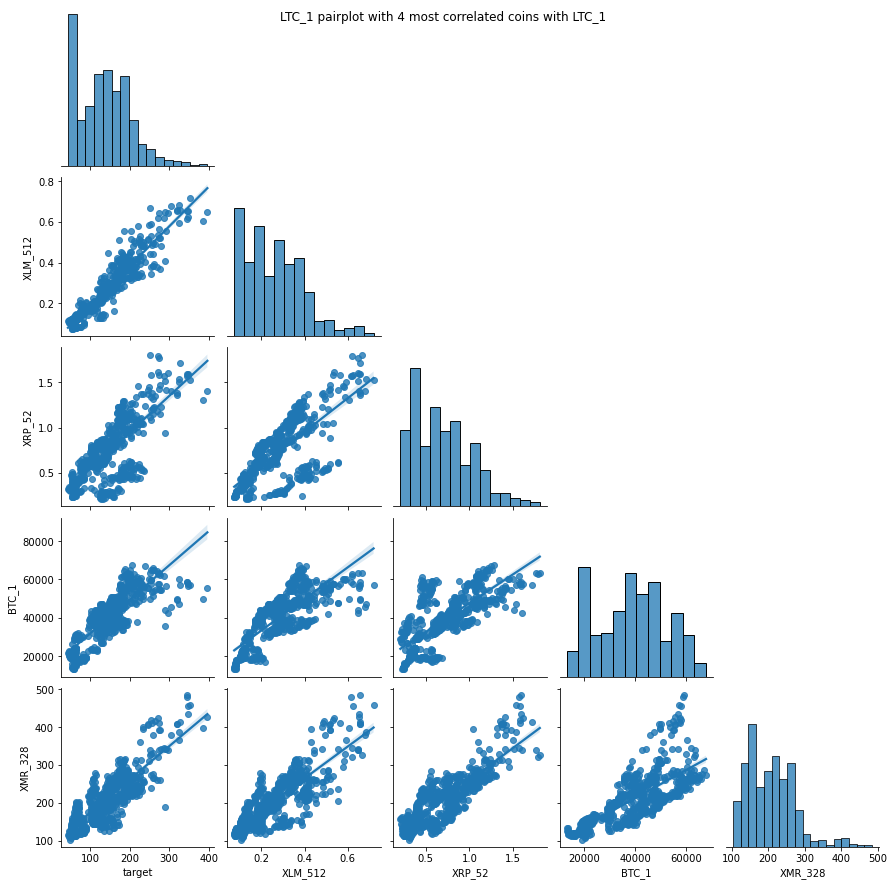

In [10]:
sns.pairplot(df[['target', 'XLM_512', 'XRP_52', 'BTC_1', 'XMR_328']], kind='reg', corner=True)
plt.suptitle('LTC_1 pairplot with 4 most correlated coins with LTC_1')
plt.show()

In [11]:
y = df[['target', 'time_close']]
x = df.drop(columns=['target'])

In [12]:
x_train = x.loc[x['time_close'] < '2022-09-03'].copy()
x_test = x.loc[x['time_close'] >= '2022-09-03'].copy()
y_train = y.loc[y['time_close'] < '2022-09-03'].copy()
y_test = y.loc[y['time_close'] >= '2022-09-03'].copy()

In [13]:
x_train.drop(columns='time_close', inplace = True)
x_test.drop(columns='time_close', inplace = True)

In [14]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [15]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# y_train['tomorrow change'] = scaler.fit_transform(y_train['tomorrow change'].values.reshape(-1, 1))
# y_test['tomorrow change'] = scaler.transform(y_test['tomorrow change'].values.reshape(-1, 1))

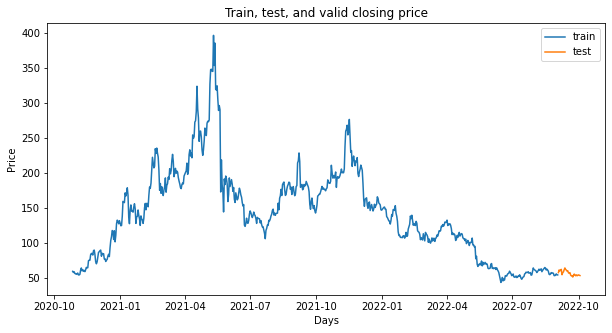

In [16]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(y_train.time_close, y_train.target, label='train')
plt.plot(y_test.time_close, y_test.target, label='test')
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Train, test, and valid closing price')
plt.legend()
plt.show()

In [17]:
train_dates = y_train['time_close'].values
test_dates = y_test['time_close'].values

y_train.drop(columns=['time_close'], inplace=True)
y_test.drop(columns=['time_close'], inplace=True)

In [18]:
param_grid = {'n_estimators':[5, 10, 25, 50, 75, 100, 250, 500, 1000]}

In [19]:
reg = lgb.LGBMRegressor()

In [20]:
grid = GridSearchCV(estimator = reg, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1, return_train_score= True)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'n_estimators': [5, 10, 25, 50, 75, 100, 250, 500,
                                          1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

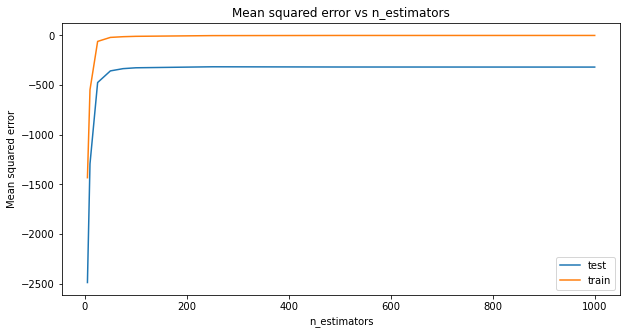

In [21]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_test_score'], label='test')
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_train_score'], label='train')
plt.ylabel('Mean squared error')
plt.xlabel('n_estimators')
plt.title('Mean squared error vs n_estimators')
plt.legend()
plt.show()

In [22]:
print(grid.best_params_)

{'n_estimators': 250}


In [23]:
# best_reg = lgb.LGBMRegressor(**grid.best_params_)
best_reg = lgb.LGBMRegressor(n_estimators = 100)
best_reg.fit(x_train, y_train)

LGBMRegressor()

In [24]:
pred = best_reg.predict(x_test)

In [25]:
mean_squared_error(y_test, pred)

1.534544683858708

In [26]:
mean_absolute_error(y_test, pred)

1.037975860101019

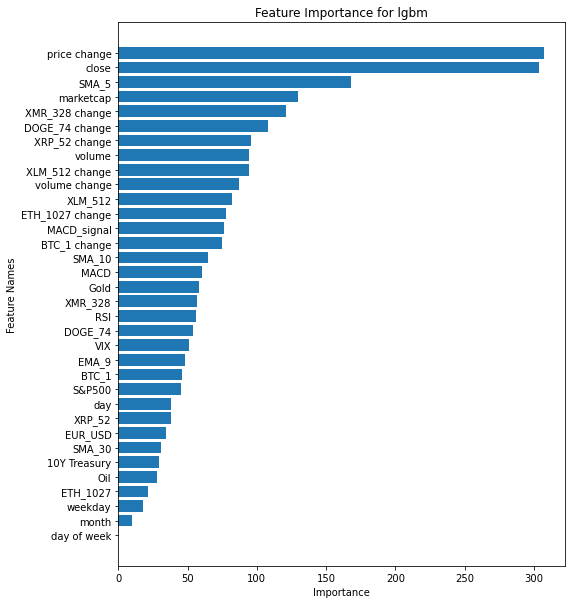

In [27]:
importance = best_reg.feature_importances_.copy()
sorted_import = importance.argsort()
fig, ax = plt.subplots(figsize = (8, 10))
plt.barh(x_train.columns[sorted_import], importance[sorted_import])
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance for lgbm')
plt.show()

In [28]:
train_pred = best_reg.predict(x_train)
mean_squared_error(y_train, train_pred)

8.387643860495665

Text(0.5, 1.0, 'Training predicted price vs actual')

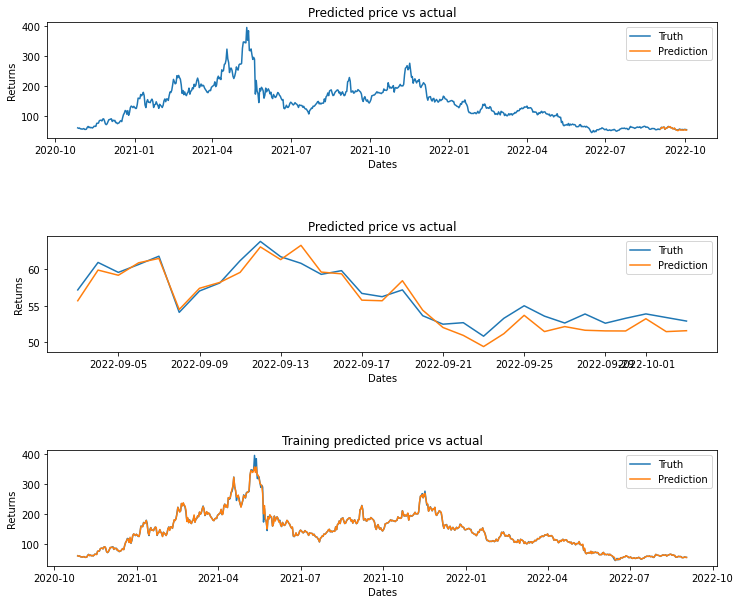

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize = (12, 10))
plt.subplots_adjust(hspace = 0.85)
ax[0].plot(train_dates, y_train['target'], 'C0', label='Truth')
ax[0].plot(test_dates, y_test['target'], 'C0')
ax[0].plot(test_dates, pred, 'C1', label='Prediction')
ax[0].legend()
ax[0].set_xlabel('Dates')
ax[0].set_ylabel('Price')
ax[0].set_title('Predicted price vs actual')

ax[1].plot(test_dates, y_test['target'], 'C0', label='Truth')
ax[1].plot(test_dates, pred, 'C1', label='Prediction')
ax[1].legend()
ax[1].set_xlabel('Dates')
ax[1].set_ylabel('Price')
ax[1].set_title('Predicted price vs actual')

ax[2].plot(train_dates, y_train['target'], 'C0', label='Truth')
ax[2].plot(train_dates, train_pred, 'C1', label='Prediction')
ax[2].legend()
ax[2].set_xlabel('Dates')
ax[2].set_ylabel('Price')
ax[2].set_title('Training predicted price vs actual')

In [30]:
# cv = TimeSeriesSplit(n_splits = 3)
# model = lgb.LGBMRegressor(n_estimators = 100)
# scoring = {'mse': make_scorer(mean_squared_error)}
# x_cv = x.copy().drop(columns='time_close')
# y_cv = y.copy().drop(columns='time_close')
# scores = cross_validate(model , x_cv, y_cv, scoring=scoring, cv=cv, return_train_score = True)

In [31]:
# scores

In [32]:
def new_predictions(coulmns):
    x_train_less = x_train[columns]
    x_test_less = x_test[columns]
    less_reg = lgb.LGBMRegressor(n_estimators = 55)
    less_reg.fit(x_train_less, y_train)
    less_pred = less_reg.predict(x_test_less)
    mes = mean_squared_error(y_test, less_pred)
    return less_pred, mes

In [33]:
highest_importance = x_train.columns[sorted_import][-14:-1]
other_importance = ['marketcap', 'weekday', 'volume', 'close', 'month', 'price change',
                    'day', 'S&P500', 'VIX', 'day of week', 'volume change', '10Y Treasury']
random_columns = ['close', 'SMA_5', 'MACD', 'RSI', 'price change']
column_list = [highest_importance, other_importance, random_columns]
prediction = []
scoring = []
for columns in column_list:
    less_pred, mes = new_predictions(columns)
    prediction.append(less_pred)
    scoring.append(mes)

Text(0.5, 1.0, 'Predicted price vs actual with 5 fetaures. Score: 1.1276592517641815')

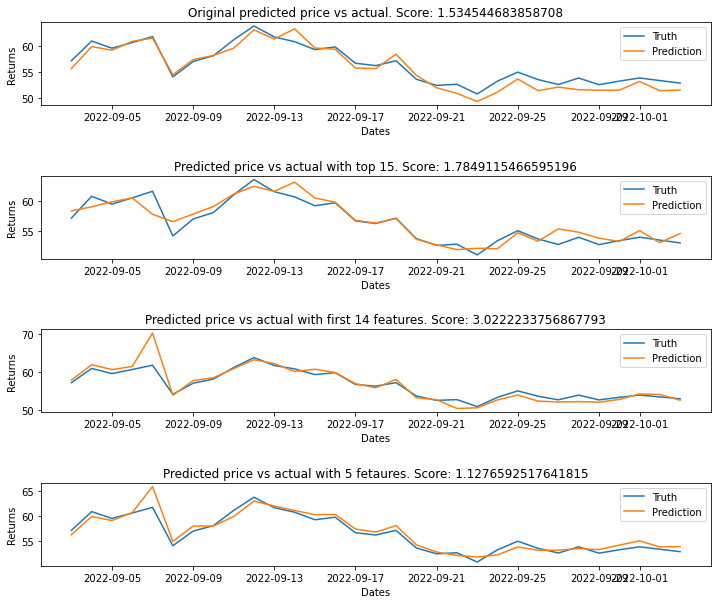

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize = (12, 10))
plt.subplots_adjust(hspace = 0.85)
ax[0].plot(test_dates, y_test['target'], 'C0', label='Truth')
ax[0].plot(test_dates, pred, 'C1', label='Prediction')
ax[0].legend()
ax[0].set_xlabel('Dates')
ax[0].set_ylabel('Returns')
ax[0].set_title('Original predicted price vs actual. Score: {}'.format(mean_squared_error(y_test, pred)))

ax[1].plot(test_dates, y_test['target'], 'C0', label='Truth')
ax[1].plot(test_dates, prediction[0], 'C1', label='Prediction')
ax[1].legend()
ax[1].set_xlabel('Dates')
ax[1].set_ylabel('Returns')
ax[1].set_title('Predicted price vs actual with top 15. Score: {}'.format(scoring[0]))

ax[2].plot(test_dates, y_test['target'], 'C0', label='Truth')
ax[2].plot(test_dates, prediction[1], 'C1', label='Prediction')
ax[2].legend()
ax[2].set_xlabel('Dates')
ax[2].set_ylabel('Returns')
ax[2].set_title('Predicted price vs actual with first 14 features. Score: {}'.format(scoring[1]))

ax[3].plot(test_dates, y_test['target'], 'C0', label='Truth')
ax[3].plot(test_dates, prediction[2], 'C1', label='Prediction')
ax[3].legend()
ax[3].set_xlabel('Dates')
ax[3].set_ylabel('Returns')
ax[3].set_title('Predicted price vs actual with 5 fetaures. Score: {}'.format(scoring[2]))